In [1]:
username = "Alex"
pathtorepo = "C:\\Users\\" *username *  "\\Desktop\\"
using Pkg
Pkg.activate(pathtorepo * "dynamical-systems\\env\\integrate\\")

  Activating project at `C:\Users\Alex\Desktop\dynamical-systems\env\integrate`


In [2]:
using DynamicalSystems, DifferentialEquations, StaticArrays, Statistics, CairoMakie

In [3]:
function sigma(x)
    return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
end

function HR(u, p, t)
        
    a, b, c, d, s, xr, r,  I, vs, k1, k2,  el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du1 = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du2 = c - d * x1 ^2 - y1
    du3 = r * ( s * ( x1 - xr ) - z1 )
    
    du4 = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du5 = c - d * x2 ^2 - y2
    du6 = r * ( s * ( x2 - xr ) - z2 )
    return SVector(du1, du2, du3,
                    du4, du5, du6)
end
Hs(x, k) = Statistics.mean(x) + k * Statistics.std(x)

Hs (generic function with 1 method)

In [4]:
function peaks(x)
    peaks_ = Float64[]
    len_ = length(x)
    for i in range(2, len_ - 1, step = 1)
        if x[i-1] < x[i] > x[i+1]
            push!(peaks_, x[i])
        end
    end
    return peaks_
end

peaks (generic function with 1 method)

In [5]:
function Tr(x, drop_size = 2)
    println("variable before truncate length: ", length(x)); flush(stdout)
    x = x[floor(Int, length(x) / drop_size):end ]
    println("variable  after truncate length: ", length(x)); flush(stdout)
    return x
end
Hs(x) = Statistics.mean(x) + 6 * Statistics.std(x)
function calc_number_EEs(x)
    threshold = Hs(x)
    counts = length(x[x.>=threshold])
    return counts
end

calc_number_EEs (generic function with 1 method)

In [6]:
a = 1.0; b = 3.0; c = 1.0; d = 5.0
xr = -1.6; r = 0.01; s = 5.0; I = 4.0; xv = 2.0
k1= -0.17; k2 = -0.17
k = 0.0
tspan = (0.0, 100000.0)

p = SA[a, b, c, d, s, xr, r, I, xv, k1, k2, k]
condition = SA[-0.04471856203156402, 0.9930479522101472, 4.4905558028862576, -1.6784956837442249, -12.985436806629679, 4.185702440686755]

6-element SVector{6, Float64} with indices SOneTo(6):
  -0.04471856203156402
   0.9930479522101472
   4.4905558028862576
  -1.6784956837442249
 -12.985436806629679
   4.185702440686755

In [7]:
prob = ODEProblem(HR, condition, tspan, p)
sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-14, reltol = 1e-14, maxiters = 10000000)

retcode: Success
Interpolation: specialized 9th order lazy interpolation, specialized 4rd order "free" stiffness-aware interpolation
t: 2779452-element Vector{Float64}:
      0.0
      0.015938375128946837
      0.025500394830765504
      0.03784939125246311
      0.04896153281833081
      0.06090775885859727
      0.07275745638495153
      0.08499858178529111
      0.0974170299766291
      0.11017808804753387
      ⋮
  99999.73552010489
  99999.7734072214
  99999.81052635997
  99999.84690583426
  99999.88264015329
  99999.91765839577
  99999.95220153387
  99999.98627933508
 100000.0
u: 2779452-element Vector{SVector{6, Float64}}:
 [-0.04471856203156402, 0.9930479522101472, 4.4905558028862576, -1.6784956837442249, -12.985436806629679, 4.185702440686755]
 [-0.036633644136989094, 0.9930267298875282, 4.491082696524066, -1.6860628963050148, -12.988093748271497, 4.184969655974476]
 [-0.03180150771516849, 0.9930373027138926, 4.491401845692747, -1.6896929233032467, -12.990543841055011, 4.1845

In [8]:
length(sol)

2779452

In [9]:
transienttime = floor(Int, length(sol)/2)

1389726

In [10]:
xsum = sol[1,transienttime:end] + sol[4,transienttime:end]
trange = sol.t[transienttime:end];

In [11]:
Hs_ = Statistics.mean(xsum) + 6 * Statistics.std(xsum)

2.6885495972429867

In [13]:
length(xsum)

1389727

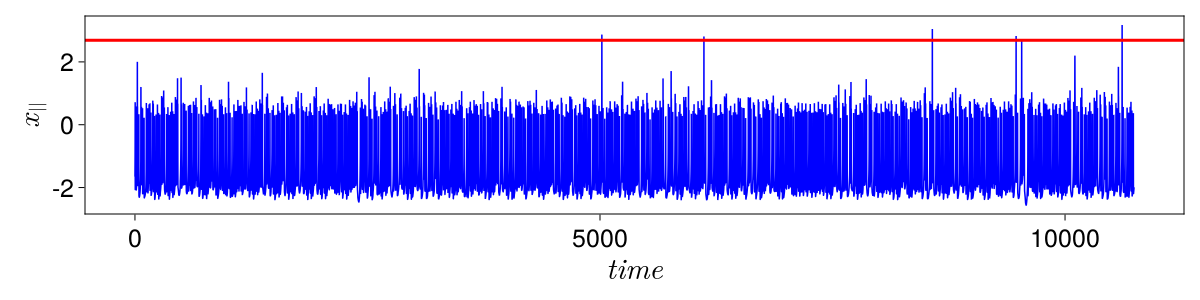

In [20]:
tstart, tend = 1, 300000
lb_size = 30; tck_size = 25;

f = Figure(resolution = (1200, 300))
axis = Axis(f[1, 1], xlabel = L"$time$", ylabel = L"$x_{||}$",
            xlabelsize = lb_size, ylabelsize = lb_size,
            xticklabelsize = tck_size, yticklabelsize = tck_size,
            xgridvisible = false, ygridvisible = false)



lines!(axis, sol.t[tstart:tend],  xsum[tstart:tend], linewiddth = 2.5, color = :blue)
hlines!(Hs_, color = "red", linewidth = 3.0)
f

In [21]:
save("timeseries_extreme_events.eps", f)

CairoMakie.Screen{EPS}


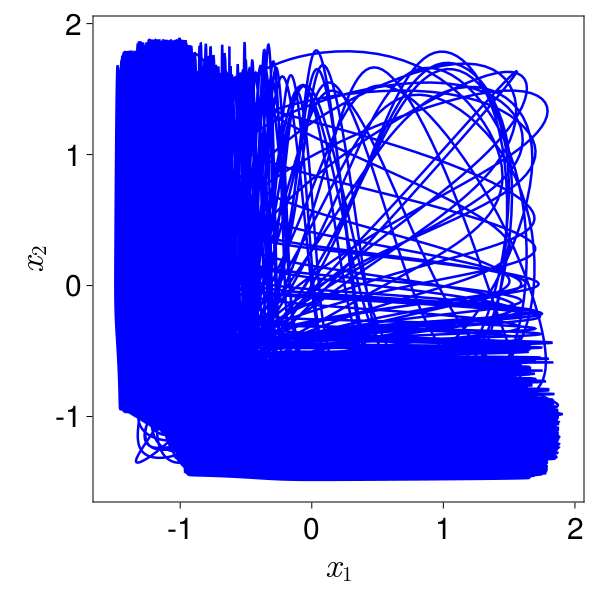

CairoMakie.Screen{IMAGE}


In [95]:
ts = transienttime; tf =  transienttime + 700000

idx, idy = 1, 4
lb_size = 35; tck_size = 30;

CairoMakie.activate!()
f = Figure(resolution = (600, 600))
ax = Axis(f[1, 1], 
            xlabel = L"x_{1}", ylabel = L"x_{2}",
            xlabelsize = lb_size, ylabelsize = lb_size,
            xticklabelsize = tck_size, yticklabelsize = tck_size,
            xgridvisible = false, ygridvisible = false)

lines!(sol[idx,transienttime:tf], sol[idy,ts:tf], linewidth = 2.5, color = :blue)

display(f)

In [96]:
save("projection_phase_porteit_extreme_events.pdf", f)

CairoMakie.Screen{PDF}
